# Shadow Index documentation
The whole project consists of 4 steps:
- Data Collection and Prepertion (cleaned and processed 500 future indexes)
- Primarily Feature seletion (shrink available choices from 500 to 17)
- Lasso Regression and Final Data Selection
- Optimal Portfolio Weight calibration

I have collection 500 future daily close prices and worked on converted monthly datas. The major purpose is to reduce the price volitality of overall portfolio as well as reduce downside risk. I and create regression model dependen on the length of maturity which makes our model more flexible on different types of contracts.

# Task 1: Data collection and preperation (monthly frequency)
### We need first to merge all indexes we found together

In [1]:
import pandas as pd
import numpy as np
import datetime 
import os
import matplotlib.pyplot as plt
%matplotlib inline
def update_df2(this_df,df):
    '''
    This function aims to merge two time series into one dataframe
    And it also fill missing dates with extra column
    '''
    df['Date']=pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df=df.set_index('Date')
    df.index = pd.DatetimeIndex(df.index)
    #remove the duplicated index
    df = df[~df.index.duplicated()]
    df = df.reindex(idx)
    try:
        df=df.drop(['_id'], axis=1)     
    except:
        pass
    
    # merge two data 
    if len(this_df)==0:
        if len(df)!=0:
            this_df=df
    else:
        this_df=pd.concat([this_df,df],axis=1)
    return this_df

# setup necessaty parameter
path = 'C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/'
idx = pd.date_range('2001-01-03', '2019-04-30')
csv_files  = []
xlsx_files = []
this_df    = []
maturity   = 5   # adjust this accourding to different situations 

### Get the list of future price files

In [2]:
for r, d, f in os.walk(path):
    for file in f:
        if '.csv' in file:
            csv_files.append(os.path.join(r, file))
        if '.xlsx' in file:
            xlsx_files.append(os.path.join(r, file))
print(len(xlsx_files))

10


In [3]:
# concate and merge all the dataframes
for file in csv_files:
    df=pd.read_csv(file)
    this_df = update_df2(this_df,df)

for file in xlsx_files:
    df=pd.read_excel(file)
    print(file)
    this_df = update_df2(this_df,df)
# save daily data to one csv

this_df.to_csv('C:/Users/richard/Documents/stable/algorithm hedging/usable index/daily_index.csv')
print(np.shape(this_df))

C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/daily 2000 bean active future.xlsx
C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/daily 2000 cocoa active futures.xlsx
C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/daily 2000 coffee active futures.xlsx
C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/daily 2000 copper active future.xlsx
C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/daily 2000 corn active future.xlsx
C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/daily 2000 lead active futures.xlsx
C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/daily 2000 nickel active future.xlsx
C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/daily 2000 rice active future.xlsx
C:/Users/richard/Documents/stable/algorithm hedging/usable index/pricefiles/daily 2000 soybean active 

### Outlier adjustment working on excel:
The extreme change will create large bias in linear regression as well as correlation calculation
Example: take the average to remove the sudden change in price. 
<img src="picture/adjust_0.png" />
$$ \downarrow $$
$$ \downarrow $$
$$ \downarrow $$
<img src="picture/adjust_1.png" />
File adjusted:
- **'cattle active future.csv'**
    - BMF-LIVE CATTLE TRc1 - SETT. PRICE - C /TE     BMYC.01      C
    - CME-FEEDER CATTLE COMP. CONT. AVG. - SETT. PRICE - UC/LB     CFDCS05      UC
    - BMF-LIVE CATTLE TRc6 - SETT. PRICE - C /TE     BMYC.06      C
    - BMF-LIVE CATTLE TRc7 - SETT. PRICE - C /TE     BMYC.07      C
    - BMF-LIVE CATTLE TRc8 - SETT. PRICE - C /TE     BMYC.08      C
    

### Convert daily data into monthly data and calculate return rate

In [2]:
''' convert daily data to monthly frequency '''
this_df=pd.read_csv('C:/Users/richard/Documents/stable/algorithm hedging/usable index/daily_index.csv',index_col=0)
this_df.index = pd.DatetimeIndex(this_df.index,dayfirst=True)
groups = this_df.resample('M')
monthly_data = groups.mean()
monthly_data.index=monthly_data.index.strftime('%b-%y')
#monthly_data = pd.concat([monthly_data,df],axis=1)
monthly_data.to_csv('C:/Users/richard/Documents/stable/algorithm hedging/usable index/monthly_index.csv')
''' calculate return ratio per future during maturity period'''
return_ratio=(monthly_data.iloc[maturity:,:]-monthly_data.iloc[:-maturity,:].values).divide(monthly_data.iloc[:-maturity,:].values)

C:\Users\richard\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (14,21,28,29,30,31,34,35,39,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
return_ratio.isna().sum().sum()

0

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------
# Task 2: Clustering and Primary Variable Selection 

Hierarchy cluster based on three similarity matrixs:
- DTW distance matrix
- Correlation Matrix
- ED Matrix.

K-means clustering based on following traits: **(UNCONFIRMED)**
- Mean
- std
- GARCH

-------------------------------------------------------------------------------------------------------------------------------
Dynamic time warping is an algorithm used to measure similarity between two sequences which may vary in time or speed. It works as follows:
- Divide the two series into equal points.
- Calculate the euclidean distance between the first point in the first series and every point in the second series. Store the minimum distance calculated. (this is the ‘time warp’ stage)
- Move to the second point and repeat 2. Move step by step along points and repeat 2 till all points are exhausted.
- Repeat 2 and 3 but with the second series as a reference point.
- Add up all the minimum distances that were stored and this is a true measure of similarity between the two series.

The steps above have followed some constraints in order to optimize the solution found. Without these constraints, with every grid added there would be an exponential increase in the different ways to pick points at which to calculate distances.
<img src="picture/1_BaDgYjm9WHd1Y6aelzPfZw.png" />



### Now, Demonstrate Dynamic Time Warping with our cleaned data

In [4]:
from dtw import dtw
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import norm
from numpy import array
import matplotlib.pyplot as plt
import datetime
from fastdtw import fastdtw
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
import operator
sns.set_style("whitegrid", {'font_scale':0.9,
                           'font.scale':0.9,
                           'xtick.color':'#A5A5A5',
                           'ytick.color':'#A5A5A5',
                           'axes.linewidth': 0.2,
                           'axes.facecolor': '#EEEEEE',
                           'text.color': '#424242',
                           'legend.frameon': True})

In [5]:
def show_case_dtw(a,b):
    x = array(return_ratio.iloc[:,a]).reshape(-1, 1)
    y = array(return_ratio.iloc[:,b]).reshape(-1, 1)
    print(list(return_ratio)[a])
    print(list(return_ratio)[b])
    plt.figure(figsize=(10,5))
    plt.plot(x)
    plt.plot(y)
    plt.title('Future Return Rate', fontsize=22)
    plt.show()

    dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
    # acc.T is the accumulated cost matrix returned from the dtw( ) function.
    # origin is which part of the chart to start the plot.
    # cmap is shorthand for color map. The 'prism' palette is particularly useful for visualizing DTW outputs.
    plt.figure(figsize=(10.3,10.3))
    plt.imshow(acc.T, origin='lower', cmap='tab20c', interpolation='nearest')
    plt.colorbar()
    plt.title('Cummulative Distance', fontsize=22)
    plt.plot(path[0], path[1], 'w')
    plt.xlim((-0.5, acc.shape[0]-0.5))
    plt.ylim((-0.5, acc.shape[1]-0.5))
    plt.show()
    plt.clf() # Clear the current figure in-case we want to generate or try a different plot.
    print(dist)
    return None

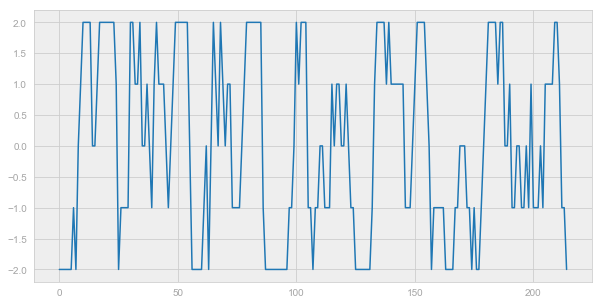

In [6]:
def discrete(x):
    x1=[]
    for i in x:
        if i>0.05 and i<0.2:
            x1.append(1)
        elif i<-0.05 and i>-0.2:
            x1.append(-1)
        elif i>=0.2:
            x1.append(2)
        elif i<=-0.2:
            x1.append(-2)
        else:
            x1.append(0)
    return x1

x = array(return_ratio.iloc[:,3]).reshape(-1, 1)
plt.figure(figsize=(10,5))
#plt.plot(x)
plt.plot(discrete(x))

### show you the relation between DTW distance and index performance

BOc3    SOYBEAN OIL DE/d
BOc3    SOYBEAN OIL DE/d


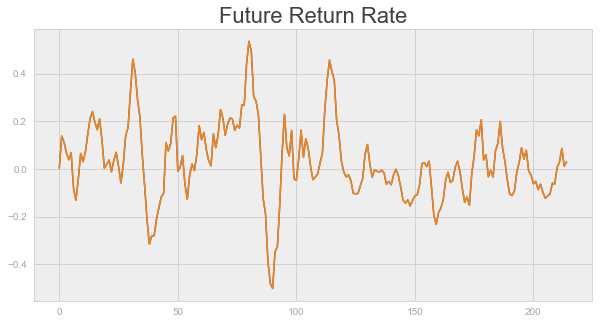

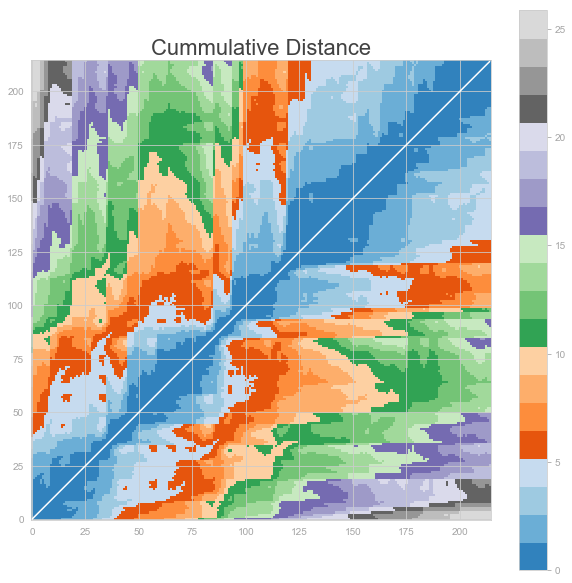

0.0


<Figure size 432x288 with 0 Axes>

In [44]:
show_case_dtw(2,2)

### Calculate DTW distance matrix and other distance matrixs 
**It is designed for hieriacial clustering / k-means clustering. Not implemented yet**

In [ ]:
''' Calculate DTW Matrix'''
n_col=np.shape(return_ratio)[1]
DTW_matrix=np.zeros((n_col,n_col))
for col in range(n_col):
    print(col)
    for row in range(n_col):
        if col>row:
            DTW_matrix[col,row]=DTW_matrix[row,col]
        else:
            x = array(return_ratio.iloc[:,col]).reshape(-1, 1)
            y = array(return_ratio.iloc[:,row]).reshape(-1, 1)
            distance, path = fastdtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
            DTW_matrix[col,row]=distance
np.savetxt("C:/Users/richard/Documents/stable/algorithm hedging/usable index/DTW_matrix.csv", DTW_matrix, delimiter=",")

0


In [122]:
''' Calculate ED Matrix'''
n_col=np.shape(return_ratio)[1]
ED_matrix=np.zeros((n_col,n_col))
ED_matrix=pd.DataFrame(ED_matrix)
ED_matrix.columns=list(return_ratio)
for col in range(n_col):
    for row in range(n_col):
        if col>row:
            ED_matrix.iloc[col,row]=ED_matrix.iloc[row,col]
        else:
            x = array(return_ratio.iloc[:,col]).reshape(-1, 1)
            y = array(return_ratio.iloc[:,row]).reshape(-1, 1)
            distance = euclidean(x,y)
            ED_matrix.iloc[col,row]=distance
ED_matrix.to_csv("C:/Users/richard/Documents/stable/algorithm hedging/usable index/ED_matrix.csv")

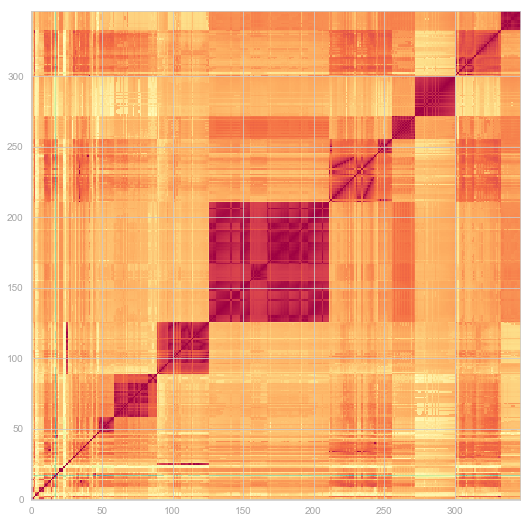

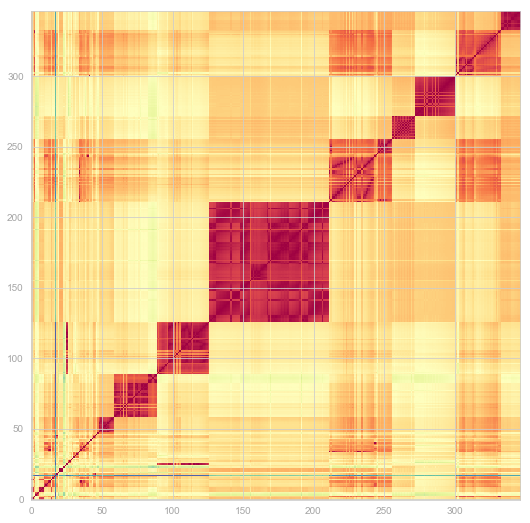

In [115]:
plt.figure(figsize=(9,9))
plt.imshow(DTW_matrix, origin='lower',interpolation='nearest',cmap='Spectral')
plt.figure(figsize=(9,9))
plt.imshow(ED_matrix, origin='lower',interpolation='nearest',cmap='Spectral')

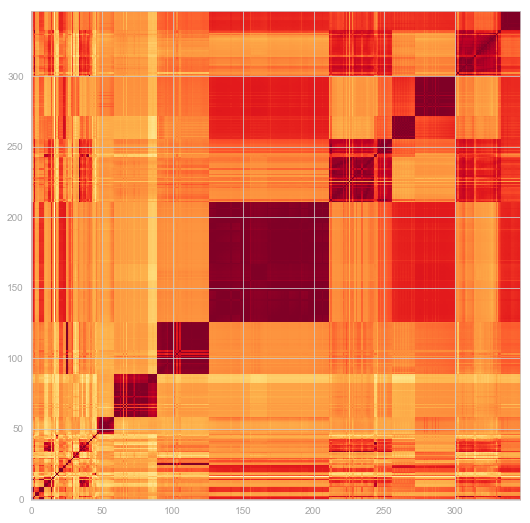

In [118]:
from scipy.stats.stats import pearsonr 
plt.figure(figsize=(9,9))
plt.imshow(return_ratio.corr(), origin='lower', cmap='YlOrRd', interpolation='nearest')

### Load our targeted index

In [7]:
target_col=2 #target index
dataset=pd.read_excel("C:/Users/richard/Documents/stable/algorithm hedging/usable index/UK_index222.xlsx",index_col=0)
''' fill the missing value with the average of the nearby data'''
for ii,i in enumerate(dataset.index):
    for jj,j in enumerate(dataset):
        if str(dataset.iloc[ii,jj])=='nan':
            try:
                if str(dataset.iloc[ii+1,jj])=='nan':
                    dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
                else:
                    dataset.iloc[ii,jj]=(dataset.iloc[ii-1,jj]+dataset.iloc[ii+1,jj])/2
            except:
                dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]

target_return_ratio= (dataset.iloc[maturity:,:]-dataset.iloc[:-maturity,:].values).divide(dataset.iloc[:-maturity,:].values)
target_return_ratio.index=target_return_ratio.index.strftime('%b-%y')

Y=target_return_ratio.iloc[:,target_col]
array_1=array(Y).reshape(-1, 1)
target_return_ratio=target_return_ratio.drop(target_return_ratio.columns[target_col], axis=1)
final_return_ratio=pd.concat([return_ratio,target_return_ratio],axis=1)

In [13]:
DTW_dist    =  {}
ED_dist     =  {}
Cor_dist    =  {}
ROI_dist    =  {}
def discrete(x):
    x1=[]
    for i in x:
        if i>0.05 and i<0.2:
            x1.append(1)
        elif i<-0.05 and i>-0.2:
            x1.append(-1)
        elif i>=0.2:
            x1.append(2)
        elif i<=-0.2:
            x1.append(-2)
        else:
            x1.append(0)
    return x1

''' as clustering is not a necessacity, just find the closest few datas '''
for item in list(final_return_ratio):
    y = array(final_return_ratio.loc[:,item]).reshape(-1, 1)
    distance, path = fastdtw(array_1, y, dist=lambda x, y: norm(x - y, ord=1))
    DTW_dist[item] = distance
    ED_dist[item]  = euclidean(array_1,y)
    Cor_dist[item] = pearsonr(array_1,y)
    ROI_dist[item] = euclidean(discrete(array_1),discrete(y))

In [12]:
Cor_dist

{'CLc1    LIGHT CRUDE SE/d': (array([-0.06093168]), array([0.3739752])),
 'LCOc1    BRENT CRUDE OC/d': (array([-0.04475589]), array([0.51391638])),
 'BOc3    SOYBEAN OIL DE/d': (array([-0.005937]), array([0.93103176])),
 'NGc1    NAT GAS SEP19/d': (array([-0.15275955]), array([0.02509092])),
 'NGc2    NAT GAS OCT19/d': (array([-0.24197666]), array([0.00034261])),
 'NGc3    NAT GAS NOV19/d': (array([-0.32635308]), array([9.98248562e-07])),
 'HOc1    NY H ULSD SEP9/d': (array([-0.09352592]), array([0.17182551])),
 'LGOc1    GAS OIL SEP9/d': (array([-0.10987487]), array([0.10815141])),
 'HOc2    NY H ULSD OCT9/d': (array([-0.12030715]), array([0.07837999])),
 'BL2c5    M.WHEAT EUR SE/d': (array([-0.06794392]), array([0.32139654])),
 'BL2c4    M.WHEAT EUR MA/d': (array([-0.06872202]), array([0.31587311])),
 'BL2c3    M.WHEAT EUR MA/d': (array([-0.06697447]), array([0.32836547])),
 'Wc2    WHEAT SRW DEC9/d': (array([-0.10947077]), array([0.10946259])),
 'Wc1    WHEAT SRW SEP9/d': (array([-0

In [96]:
sorted_DTW_dist = dict(sorted(DTW_dist.items(), key=operator.itemgetter(1),reverse=False))
sorted_ED_dist = dict(sorted(ED_dist.items(), key=operator.itemgetter(1),reverse=False))
sorted_Cor_dist = dict(sorted(Cor_dist.items(), key=operator.itemgetter(1),reverse=True))
sorted_ROI_dist = dict(sorted(ROI_dist.items(), key=operator.itemgetter(1),reverse=False))
result=list(sorted_DTW_dist.keys())[:7]+list(sorted_ED_dist.keys())[:7]+list(sorted_Cor_dist.keys())[:7]+list(sorted_ROI_dist.keys())[:7]
result=list(set(result))

In [97]:
# this shows our choices of relevant future options
result

['CBT-SOYBEANS COMP. C.3RD.LT - SETT. PRICE    CSYCS31    UC',
 'BL2c4    M.WHEAT EUR MA/d',
 'GB29',
 'ECBOT-SOYBEAN MEAL C.4TH.LT - SETT. PRICE    CZMCS41    U$',
 '002TYc1^1    The record could not be found',
 'CSCE-COCOA CONT. 5TH FUT - SETT. PRICE - U$/TE    NCCCS50    U$',
 'TGE-AZUKI (RED BEAN) TRc1 - SETT. PRICE - Y /HK   JRBC.01    Y',
 'GB28',
 'TGE-AZUKI (RED BEAN) CONT. INDEX - SETT. PRICE - Y /HK   JRBCS04    Y',
 'TGE-AZUKI (RED BEAN) CONTINUOUS LTDT - SETT. PRICE - Y /HK   JRBCS01    Y',
 'TGE-AZUKI (RED BEAN) CONTINUOUS WVOL - SETT. PRICE - Y /HK   JRBCS02    Y',
 'BOc1    SOYBEAN OIL AU/d',
 'GB24',
 'CSCE-COCOA C.9TH.FT - SETT. PRICE    NCCCS90    U$',
 'CSCE-COCOA C.7TH.FT - SETT. PRICE    NCCCS70    U$']

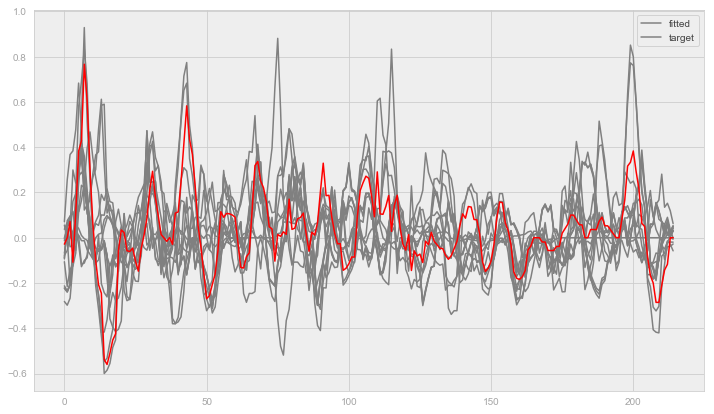

In [98]:
# a sample price movement of one of choosed index and target index 
plt.figure(figsize=(12,7))

plt.plot(final_return_ratio.loc[:,result[:]].values,color='grey')
plt.plot(Y.values,color='red')
plt.legend(['fitted','target'])


# Task 3: LASSO regression and Final variable selection
Ridge and Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression. But in this case, lasso algotithm serves as a method to select most important 5 variables. 

**Selection process includes:**
- correlation analysis
- Recursive Feature Elimination
- Tree based feature selection
- Ridge and Lasso Regression

In [43]:
''' create our training data'''
final_df1=final_return_ratio.loc[:,result]
final_df1['Y']=Y.values
clipped_df=final_df1.clip(-0.2, 0.2)

Train_X1 = final_df1.iloc[:-50,:-1]
Train_Y1 = final_df1.iloc[:-50,-1]
Test_X1  = final_df1.iloc[:,:-1]
Test_Y1  = final_df1.iloc[:,-1]

Train_X2 = clipped_df.iloc[:-50,:-1]
Train_Y2 = clipped_df.iloc[:-50,-1]
Test_X2  = final_df1.iloc[:,:-1]
Test_Y2  = final_df1.iloc[:,-1]

NameError: name 'final_return_ratio' is not defined

### First, we try the basic l inear regression and treat this as a reference for feature selection 
(Thinking about implement linear regression with a different loss-function rather than MSE )

[-1.40775630e-01 -1.18548251e-02  5.10917682e-02  1.83609723e-01
 -7.59910005e-02  2.50920359e-01 -6.13876543e+01  5.81963137e-01
  8.37034513e-02  6.21702435e+01 -9.12960248e-01  9.59525286e-02
  1.94482512e-01  6.81469734e-02 -1.69678244e-01]


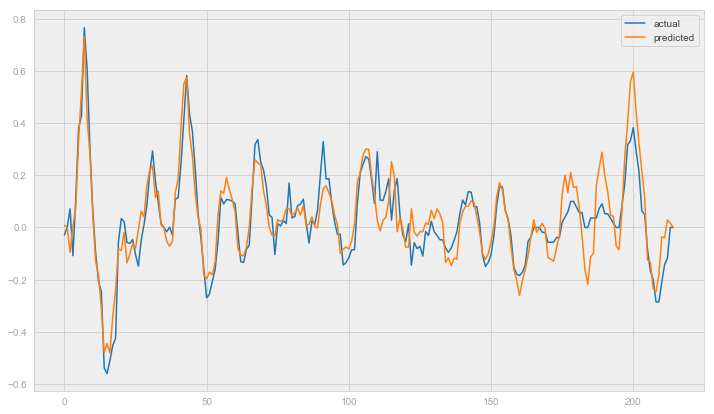

In [100]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression(normalize=True)
linreg.fit(Train_X1,Train_Y1)
print(linreg.coef_)
y_pred = linreg.predict(Test_X1)
plt.figure(figsize=(12,7))
plt.plot(Test_Y1.values)
plt.plot(y_pred)
plt.legend(['actual','predicted'])

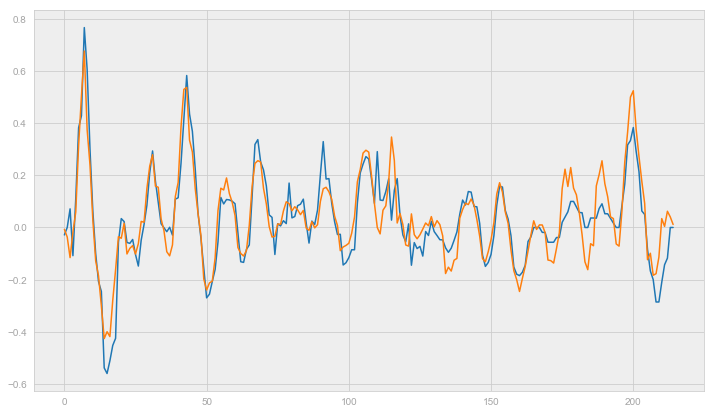

In [101]:
# Here i clipped the upper/lower price change rates to avoid exteme price movement
linreg2 = LinearRegression(normalize=True)
linreg2.fit(Train_X2,Train_Y2)
y_pred2 = linreg2.predict(Test_X2)
plt.figure(figsize=(12,7))
plt.plot(Test_Y2.values)
plt.plot(y_pred2)

In [102]:
print([round(i,2) for i in linreg.coef_])
print([round(i,2) for i in linreg2.coef_])

[-0.14, -0.01, 0.05, 0.18, -0.08, 0.25, -61.39, 0.58, 0.08, 62.17, -0.91, 0.1, 0.19, 0.07, -0.17]
[0.06, -0.06, 0.01, -0.02, 0.04, 0.17, -69.13, 0.54, 0.06, 69.83, -0.79, 0.05, 0.29, 0.05, -0.09]


### Now implement feature selection algorithms

#### Basic correlation analysis to remove uninformative columns

'From result, we can remove 1,2,3,7,10'

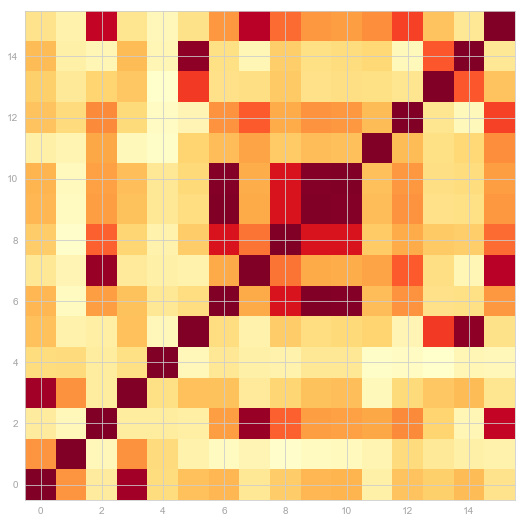

In [103]:
plt.figure(figsize=(9,9))
plt.imshow(final_df1.corr(), origin='lower', cmap='YlOrRd', interpolation='nearest')
'''From result, we can remove 1,2,3,7,10'''

----
#### Recursive Feature Elimination

In [42]:
from sklearn.feature_selection import RFECV
# Create recursive feature eliminator that scores features by mean squared errors
ols=LinearRegression(normalize=True)
rfecv = RFECV(estimator=ols, step=1, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
rfecv.fit(Train_X1, Train_Y1)
# Recursive feature elimination
rfecv.transform(Train_X1)
print(rfecv.n_features_)
print(rfecv.support_)
print(rfecv.ranking_)
plt.figure(figsize=(10,7))
plt.xlabel("Number of features selected",fontsize=16)
plt.ylabel("Cross validation score of number of selected features",fontsize=16)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

selected_1=[]
for n,i in enumerate(list(final_df1.iloc[50:,:-1])):
    if rfecv.support_[n]==True:
        selected_1.append(i)
selected_1

NameError: name 'LinearRegression' is not defined

----
#### Tree based feature selection and random forest classification

C:\Users\richard\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. feature 7 (0.756938)
2. feature 2 (0.061478)
3. feature 12 (0.048467)
4. feature 4 (0.035625)
5. feature 11 (0.020626)
6. feature 1 (0.017395)
7. feature 3 (0.008885)
8. feature 14 (0.008751)
9. feature 0 (0.008602)
10. feature 5 (0.007934)
11. feature 8 (0.007187)
12. feature 13 (0.006102)
13. feature 6 (0.004517)
14. feature 9 (0.004355)
15. feature 10 (0.003138)


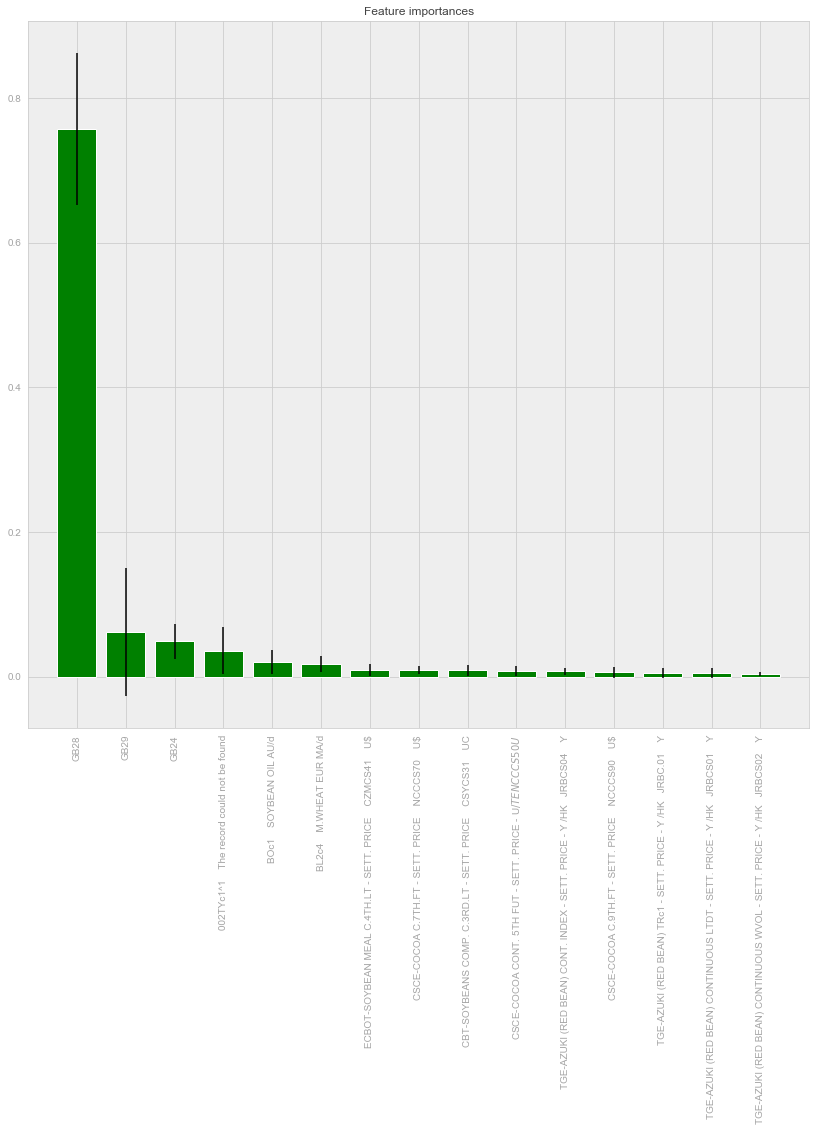

In [105]:
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor()   
clr_rf = clf_rf.fit(Train_X1,Train_Y1)
importances = clr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(Train_X1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(Train_X1.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(Train_X1.shape[1]),Train_X1.columns[indices],rotation=90)
plt.xlim([-1, Train_X1.shape[1]])
plt.show()

----
**Ridge Regression :** In ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients.
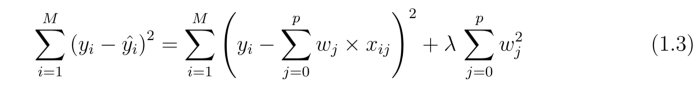

In [41]:
from sklearn.linear_model import Ridge

lr = LinearRegression()
lr.fit(Train_X1, Train_Y1)
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles

rr.fit(Train_X1, Train_Y1)
rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(Train_X1, Train_Y1)
train_score=lr.score(Train_X1, Train_Y1)
test_score=lr.score(Test_X1, Test_Y1)
Ridge_train_score = rr.score(Train_X1, Train_Y1)
Ridge_test_score = rr.score(Test_X1, Test_Y1)
Ridge_train_score100 = rr100.score(Train_X1, Train_Y1)
Ridge_test_score100 = rr100.score(Test_X1, Test_Y1)
print ("linear regression train score:", train_score)
print ("linear regression test score:", test_score)
print ("ridge regression train score low alpha:", Ridge_train_score)
print ("ridge regression test score low alpha:", Ridge_test_score)
print ("ridge regression train score high alpha:", Ridge_train_score100)
print ("ridge regression test score high alpha:", Ridge_test_score100)
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()



NameError: name 'LinearRegression' is not defined

[-0.14422808 -0.01092617  0.05323339  0.18444841 -0.06986502  0.21789744
  0.31870638  0.57632042  0.08029783  0.32288413 -0.75941884  0.09905297
  0.19738471  0.07475631 -0.13987104]


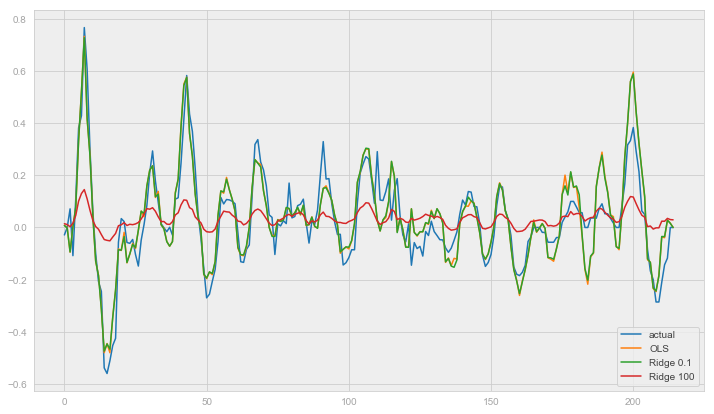

In [108]:
y_pred1=lr.predict(Test_X1)
y_pred2=rr.predict(Test_X1)
y_pred3=rr100.predict(Test_X1)
plt.figure(figsize=(12,7))
plt.plot(Test_Y1.values)
plt.plot(y_pred1)
plt.plot(y_pred2)
plt.plot(y_pred3)
plt.legend(['actual','OLS','Ridge 0.1','Ridge 100'])
print(rr.coef_)

----
#### Lasso Regression : 
The cost function for Lasso (least absolute shrinkage and selection operator) regression can be written as
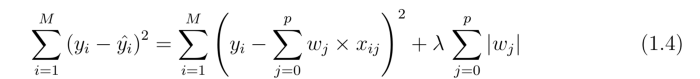
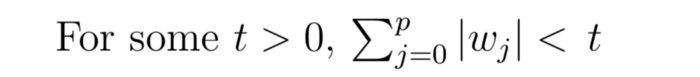
So Lasso regression not only helps in reducing over-fitting but it can help us in feature selection. The difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are completely neglected

In [40]:
from sklearn.linear_model import Lasso
train_score,test_score,coeff_used=[],[],[]
alphas=[0.0005*i for i in range(21)]
for alpha in alphas:
    lasso = Lasso(alpha, max_iter=10e5)
    lasso.fit(Train_X1, Train_Y1)
    train_score.append(lasso.score(Train_X1, Train_Y1))
    test_score.append(lasso.score(Test_X1, Test_Y1))
    coeff_used.append(np.sum(lasso.coef_!=0))

plt.figure(figsize=(12,7))
plt.subplot(3,1,1)
plt.plot(alphas,train_score) 
plt.title('Trainset accuracy')
plt.subplot(3,1,2)
plt.plot(alphas,test_score) 
plt.title('Testset accuracy')
plt.subplot(3,1,3)
plt.plot(alphas,coeff_used) 
plt.title('Number of covariance selected')



NameError: name 'Train_X1' is not defined

[ 0.         -0.          0.04411389  0.         -0.          0.
  0.          0.58659573  0.          0.          0.          0.05100572
  0.14072192  0.04137395  0.        ]


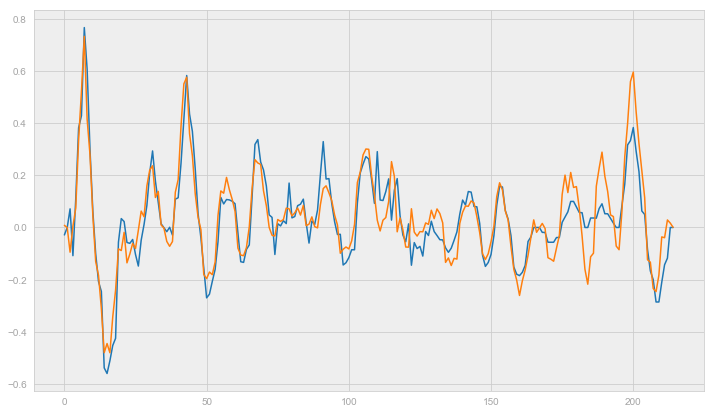

In [110]:
lasso = Lasso(0.0022, max_iter=10e7)
lasso.fit(Train_X1, Train_Y1)
print(lasso.coef_)
y_pred=lasso.predict(Test_X1)
plt.figure(figsize=(12,7))
plt.plot(Test_Y1.values)
plt.plot(y_pred1)


In [66]:
np.array(list(Train_X1))[lasso.coef_!=0]

array(['GB29', 'GB28', 'BOc1    SOYBEAN OIL AU/d', 'GB24',
       'CSCE-COCOA C.9TH.FT - SETT. PRICE    NCCCS90    U$'], dtype='<U73')

-----
#### Conclude:
Based on all prior conclusion, we choose 11,6,15,5,8 as our replicating portfolio

# Task 4: Look for the optimal portfolio weights
To achieve this, another OLS regression will be adequate. But here I implement ridge regression to ensure coefficents are not explosively big, which is not implementable for hedging.

Selected Future contracts are:
CSCE-COCOA CONT. 5TH FUT - SETT. PRICE - U$/TE    NCCCS50    U$
GB28
BOc1    SOYBEAN OIL AU/d
GB24


C:\Users\richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(array([0.15041407, 0.47260895, 0.10805841, 0.15399324]),
 array([0.14981955, 0.47187738, 0.10800708, 0.1539337 ]))

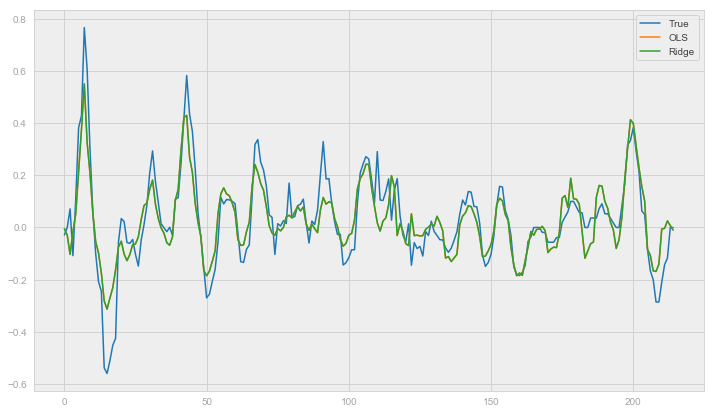

In [112]:
def train_with_selection(cols,alpha):
    final_df1 = final_return_ratio.loc[:,result]
    filtered_df1 = final_df1.iloc[:,cols]
    filtered_df1['Y'] =Y.values


    Train_X1 = filtered_df1.iloc[50:,:-1]
    Train_Y1 = filtered_df1.iloc[50:,-1]
    Test_X1  = filtered_df1.iloc[:,:-1]
    Test_Y1  = filtered_df1.iloc[:,-1]
    linreg = LinearRegression()
    linreg.fit(Train_X1,Train_Y1)
    y_pred = linreg.predict(Test_X1)


    rr = Ridge(alpha) 
    rr.fit(Train_X1, Train_Y1)
    y_pred2 = rr.predict(Test_X1)

    plt.figure(figsize=(12,7))
    plt.plot(Test_Y1.values)
    plt.plot(y_pred)
    plt.plot(y_pred2)
    plt.legend(['True','OLS','Ridge'])
    print('Selected Future contracts are:')
    for i in list(filtered_df1)[:-1]:
        print(i)
    return linreg.coef_,rr.coef_,y_pred2
linreg.coef_,rr.coef_,y_pred2=train_with_selection([5,7,11,12],0.01)
linreg.coef_,rr.coef_

#### The result above shows column nuber 8,15 is not important yet, Let's check it via another plot

Selected Future contracts are:
CSCE-COCOA CONT. 5TH FUT - SETT. PRICE - U$/TE    NCCCS50    U$
GB28
GB24


C:\Users\richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(array([0.15755759, 0.48432127, 0.17425042]),
 array([0.15693348, 0.48357897, 0.17412986]))

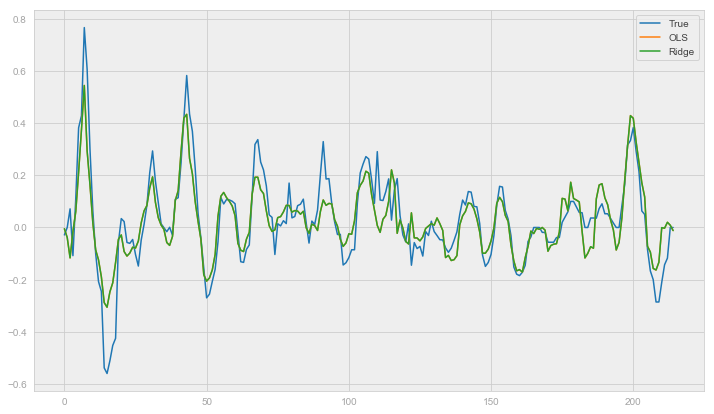

In [113]:
linreg.coef_,rr.coef_,y_pred2=train_with_selection([5,7,12],0.01)
linreg.coef_,rr.coef_

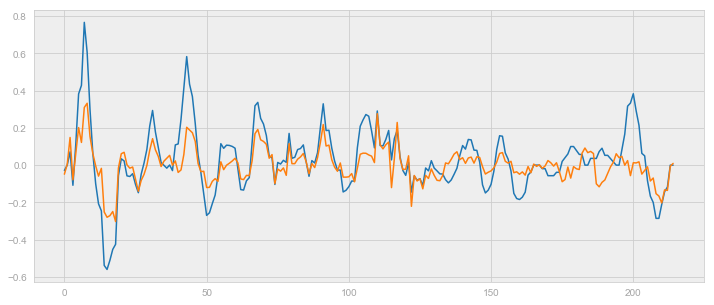

0.17713434369313785
0.08735185455298193


In [114]:
plt.figure(figsize=(12,5))
plt.plot(Y.values)
plt.plot(Y.values-y_pred*0.7)
plt.show()
print(np.std(Y.values))
print(np.std(Y.values-y_pred2))

-----
# Task 5: proposed future plan and potential improvement:
1. Change the loss equation. Currently loss equation aims to make to price movement as similar as positible. However, rather than reduce volitality, we also primarily aims to reduce the lost during down-turn period. As we going to short the replicating portfolio, we will perfer the resulting portfolio to decrease faster than our target index. So we should penalise more on the difference in negative area rather than simply using euclidean distance



2. I could try to use clustering method to group different index together as an alternative method in task 2 as well as to implement time-series analysis as a clustering cretiria 


The **ARCH** process introduced by Engle (1982) explicitly recognizes the difference between the unconditional and the conditional variance allowing the latter to change over time as a function of past errors.

An ARCH model is used to predict the variance at future time steps. [ARCH] are mean zero, serially uncorrelated processes with nonconstant variances conditional on the past, but constant unconditional variances. For such processes, the recent past gives information about the one-period forecast variance.

Generalized Autoregressive Conditional Heteroskedasticity, or **GARCH**, is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component.


As such, the model introduces a new parameter “p” that describes the number of lag variance terms:

    p: The number of lag variances to include in the GARCH model.
    q: The number of lag residual errors to include in the GARCH model.
A generally accepted notation for a GARCH model is to specify the GARCH() function with the p and q parameters GARCH(p, q); for example GARCH(1, 1) would be a first order GARCH model.

A GARCH model subsumes ARCH models, where a GARCH(0, q) is equivalent to an ARCH(q) model.